<a href="https://colab.research.google.com/github/andryll/MGR-IC/blob/main/codes/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importando as Bibliotecas

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from numba import jit, cuda

### Algoritmos

In [8]:
def KFoldCrossValidation(dataframe, n_splits, seed):

    target = 'Classe'
    X_columns = dataframe.columns[dataframe.columns != target]
    X = dataframe[X_columns]
    Y = dataframe[target]

    skf = StratifiedKFold(n_splits = n_splits, shuffle=True, random_state = seed)

    X_train_list = []
    X_test_list = []
    Y_train_list = []
    Y_test_list = []

    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        # Armazenar os vetores de treino e teste nas listas
        X_train_list.append(X_train.values.tolist())
        X_test_list.append(X_test.values.tolist())
        Y_train_list.append(Y_train.to_list())
        Y_test_list.append(Y_test.to_list())

    return X_train_list, X_test_list, Y_train_list, Y_test_list

In [9]:
def elbowKNN(dflist, n_neigh, seed):


  scorelist = []

  for df in dflist:
    neigh = neighbors.KNeighborsClassifier(n_neighbors= n_neigh)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        neigh.fit(X_train[i], Y_train[i])
        Y_predict = neigh.predict(X_test[i])
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist

In [10]:
def elbowTree(dflist, seed):

  scorelist = []

  for df in dflist:
    clf = tree.DecisionTreeClassifier(random_state = seed)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        clf.fit(X_train[i], Y_train[i])
        Y_predict = clf.predict(X_test[i])
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist

In [11]:
def elbowRF(dflist, seed):

  scorelist = []

  for df in dflist:
    rf = ensemble.RandomForestClassifier(random_state = seed)

    X_train, X_test, Y_train, Y_test = KFoldCrossValidation(df, n_splits = 10, seed = seed)

    auxlist = []

    for i in range(10):

        rf.fit(X_train[i], Y_train[i])
        Y_predict = rf.predict(X_test[i])
        auxlist.append(balanced_accuracy_score(Y_test[i], Y_predict))

    scorelist.append(np.mean(np.array(auxlist), axis = 0))

  return scorelist

### Testes

In [6]:
#Ler CSVs
dflist = []

csvnames = ['3s_256.csv', '3s_512.csv','3s_1024.csv','3s_2048.csv','3s_4096.csv','3s8192.csv']

for i in csvnames:
  dir_path = os.path.join('C:/Users/andry/OneDrive/Documentos/GitHub/MGR-IC/csv/3s', i)
  dflist.append(pd.read_csv(dir_path, sep=',', encoding='utf-8'))


In [12]:
# Executa os algoritmos com as features desejadas e salva os valores de score nas listas

knnscores3 = []
knnscores5 = []
knnscores7 = []
dtscores = []
rfscores = []
seeds = [14, 42, 60, 87, 113, 156, 211, 456, 917, 1001]

for seed in seeds:
  knnscores3.append(elbowKNN(dflist, n_neigh = 3, seed = seed))
  knnscores5.append(elbowKNN(dflist, n_neigh = 5, seed = seed))
  knnscores7.append(elbowKNN(dflist, n_neigh = 7, seed = seed))

  dtscores.append(elbowTree(dflist, seed = seed))
  rfscores.append(elbowRF(dflist, seed = seed))

In [13]:
# Coloca as listas de score em uma outra lista a cria listas com as médias e os sds.

scoreslist = []
scoresmeans = []
scoressds = []

scoreslist.append(np.array(knnscores3))
scoreslist.append(np.array(knnscores5))
scoreslist.append(np.array(knnscores7))
scoreslist.append(np.array(dtscores))
scoreslist.append(np.array(rfscores))

# KNN3 = 0 / KNN5 = 1 / KNN7 = 2 / DT = 3 / RF = 4

for score in scoreslist:
  scoresmeans.append(np.mean(score, axis=0))
  scoressds.append(np.std(score, axis=0))

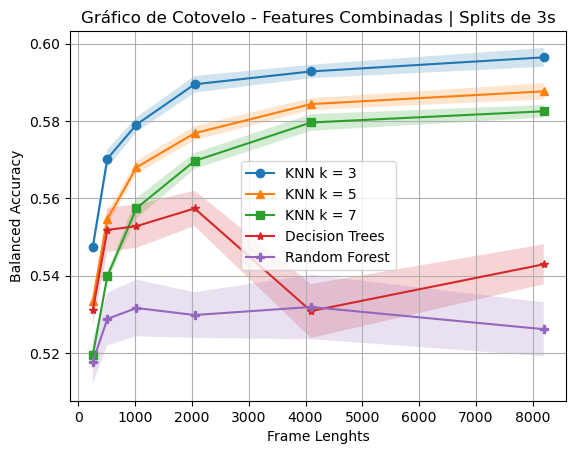

In [16]:
#  Plota o gráfico com as médias das seeds e os desvios padrão

frame_lenghts = [256, 512, 1024, 2048, 4096, 8192]
labels = ['KNN k = 3', 'KNN k = 5', 'KNN k = 7', 'Decision Trees', 'Random Forest']
markers = ['o', '^', 's', '*', 'P']

for i in range(len(scoresmeans)):
  plt.plot(frame_lenghts, scoresmeans[i], label = labels[i], marker = markers[i])
  plt.fill_between(frame_lenghts, scoresmeans[i] + scoressds[i], scoresmeans[i] - scoressds[i], alpha = 0.2)

plt.legend()
plt.grid()
plt.ylabel('Balanced Accuracy')
plt.xlabel('Frame Lenghts')
plt.title('Gráfico de Cotovelo - Features Combinadas | Splits de 3s')

# Nome do arquivo pra salvar
plt.savefig('3s.pdf')
plt.show()